In [0]:
!mv kaggle.json /root/.kaggle/
!pip install numpy-quaternion
import numpy as np
import quaternion
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import sys
import math
import keras.backend as K
import kaggle
import pickle
import pandas as pd
from keras.models import Model, Sequential
from keras.layers import Conv2D, Dense, Activation, Add, MaxPool2D, Input
from keras.layers import Deconv2D, Conv2DTranspose, UpSampling2D
from keras.applications.vgg16 import preprocess_input, decode_predictions


np.random.seed(0)
%matplotlib inline

mv: cannot stat 'kaggle.json': No such file or directory


In [0]:
!kaggle competitions download -c career-con-2019

 53% 9.00M/17.1M [00:00<00:00, 63.7MB/s]
100% 17.1M/17.1M [00:00<00:00, 84.0MB/s]
  0% 0.00/64.1k [00:00<?, ?B/s]
100% 64.1k/64.1k [00:00<00:00, 54.3MB/s]
  0% 0.00/51.1k [00:00<?, ?B/s]
100% 51.1k/51.1k [00:00<00:00, 51.2MB/s]
 52% 9.00M/17.2M [00:00<00:00, 67.7MB/s]
100% 17.2M/17.2M [00:00<00:00, 83.7MB/s]


In [0]:
!unzip X_train.csv.zip
!unzip X_test.csv.zip

Archive:  X_train.csv.zip
  inflating: X_train.csv             
Archive:  X_test.csv.zip
  inflating: X_test.csv              


In [0]:
X_train = pd.read_csv("X_train.csv")
X_test = pd.read_csv("X_test.csv")
y_train = pd.read_csv("y_train.csv")
sample_submission = pd.read_csv('sample_submission.csv')

### Data Description

X_[train/test].csv - the input data, covering 10 sensor channels and 128 measurements per time series plus three ID columns:

-row_id: The ID for this row.

-series_id: ID number for the measurement series. Foreign key to y_train/sample_submission.

-measurement_number: Measurement number within the series.

The orientation channels encode the current angles how the robot is oriented as a quaternion (see Wikipedia). Angular velocity describes the angle and speed of motion, and linear acceleration components describe how the speed is changing at different times. The 10 sensor channels are:

* orientation_X

* orientation_Y

* orientation_Z

* orientation_W

* angular_velocity_X

* angular_velocity_Y

* angular_velocity_Z

* linear_acceleration_X

* linear_acceleration_Y

* linear_acceleration_Z

y_train.csv - the surfaces for training set.

-series_id: ID number for the measurement series.

-group_id: ID number for all of the measurements taken in a recording session. Provided for the training set only, to enable more cross validation strategies.

-surface: the target for this competition.


====================================

There are 3810 series IDs, which means there are 3810 measurement sessions. 
For each series ID there are many measurements recorded. with a label for each of the session according to the surface.

Visualize the readings for each of the different surfaces to see what can be the difference

In [0]:
print(X_train.columns)
X_train.describe()

Index(['row_id', 'series_id', 'measurement_number', 'orientation_X',
       'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
       'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
       'linear_acceleration_Y', 'linear_acceleration_Z'],
      dtype='object')


,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [0]:
print(y_train.columns)
y_train.describe()

Index(['series_id', 'group_id', 'surface'], dtype='object')


,series_id,group_id
count,3810.000000,3810.000000
mean,1904.500000,37.601312
std,1099.996591,20.982743
min,0.000000,0.000000
25%,952.250000,19.000000
50%,1904.500000,39.000000
75%,2856.750000,55.000000
max,3809.000000,72.000000


In [0]:
print(X_train['series_id'].nunique())
print(y_train.surface.nunique())
print(y_train.surface.unique())
surfaces = y_train.surface.unique()

3810
9
['fine_concrete' 'concrete' 'soft_tiles' 'tiled' 'soft_pvc'
 'hard_tiles_large_space' 'carpet' 'hard_tiles' 'wood']


In [0]:
y_train = y_train.set_index(['surface'])
X_train = X_train.set_index(['series_id'])

In [0]:
samples = []
sample_idx = 10
for surf in surfaces:
    samples.append(y_train.loc[surf]['series_id'].values[sample_idx])
print(surfaces)
print(samples)

['fine_concrete' 'concrete' 'soft_tiles' 'tiled' 'soft_pvc'
 'hard_tiles_large_space' 'carpet' 'hard_tiles' 'wood']
[79, 53, 52, 67, 78, 175, 176, 798, 138]


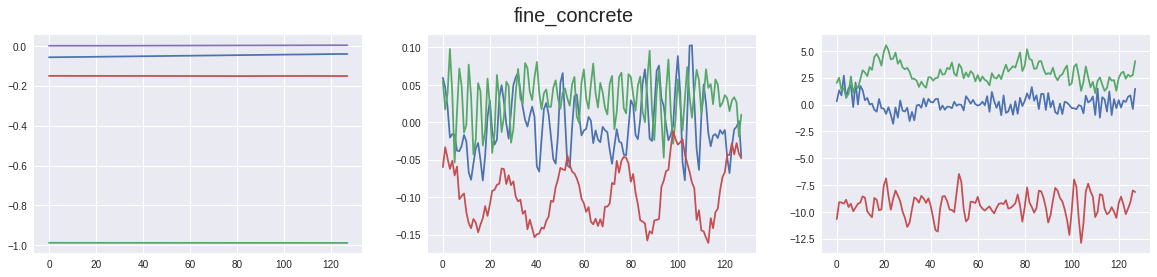

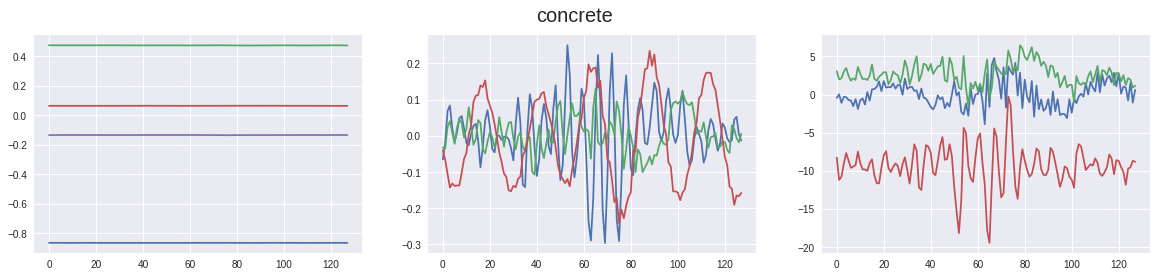

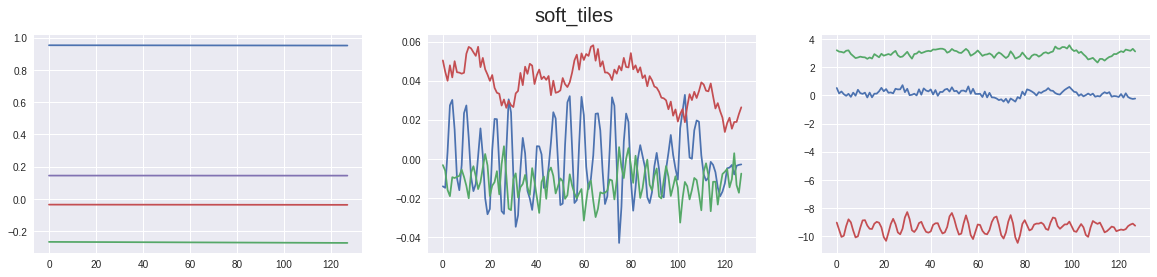

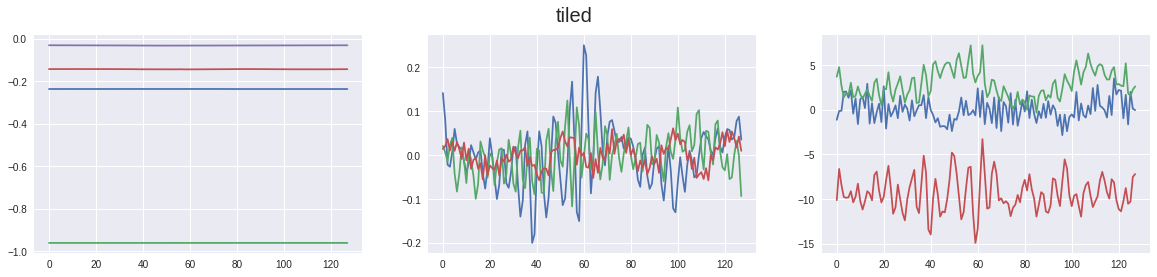

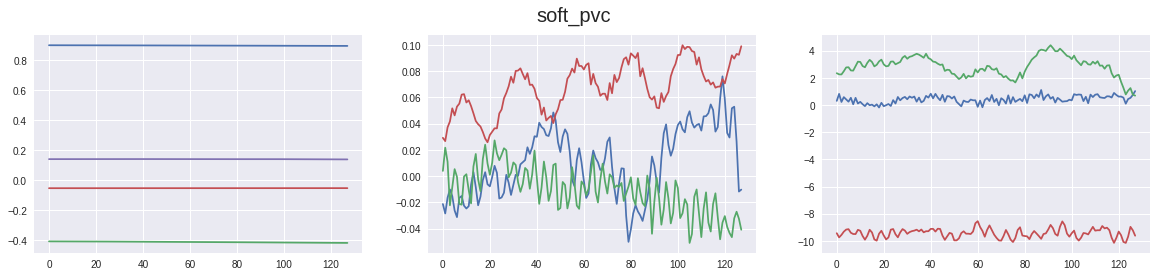

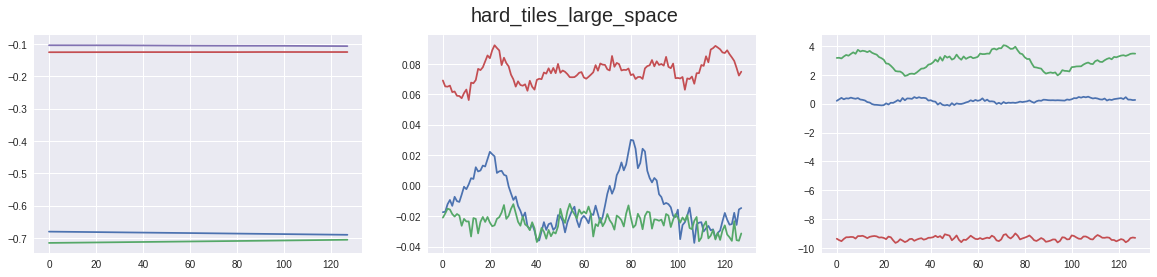

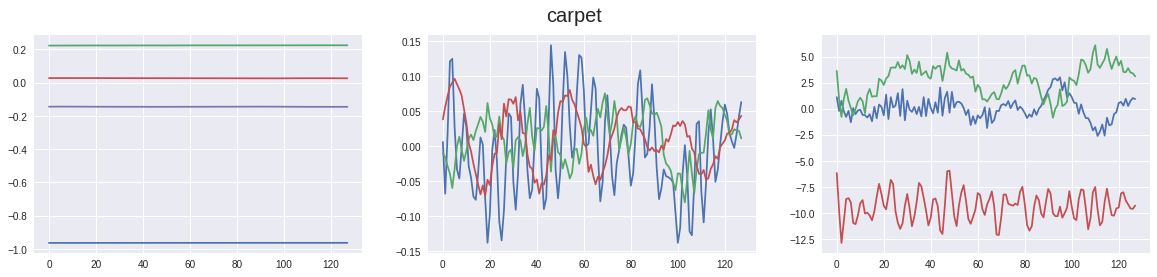

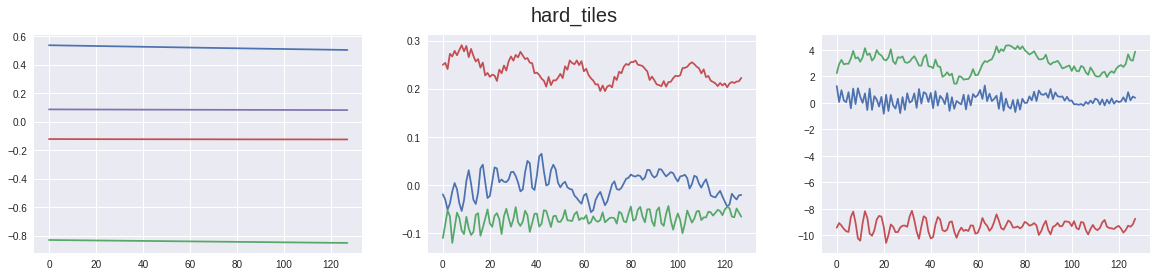

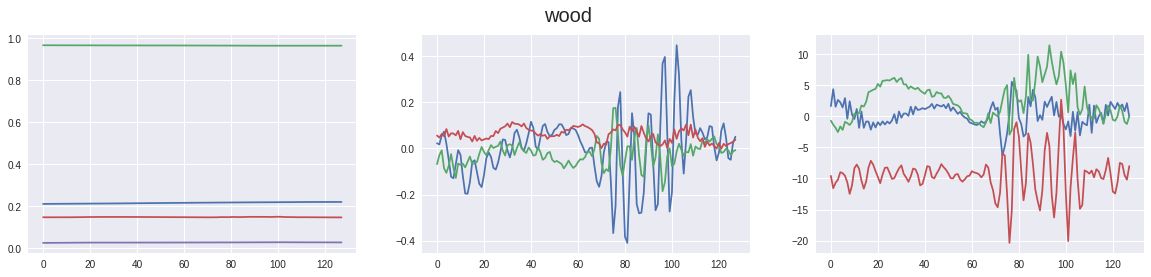

In [0]:
for i in range(len(samples)):
    measurements = X_train.loc[samples[i]]
    measurements = measurements.drop(['measurement_number', 'row_id'], axis=1)
    measurements = measurements.values
    quat = measurements[:,:4]
    plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.plot(quat)
    plt.subplot(132)
    plt.plot(measurements[:,4:7])
    plt.subplot(133)
    plt.plot(measurements[:,7:])
    plt.suptitle(surfaces[i], fontsize=20)
    
